# Without sWeights: `common_B0TODst3pi_Dst_constr`
# Fit the complete data (With sWeights and without sWeights)
- Load the fit to $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ in the LHCb data
- Compute the $_s$Weights and save them in a root files, with the training variables

In [2]:
name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

name_data = 'common_B0TODst3pi_Dst_constr'
name_data_B0toDstDs = 'common_B0TODstDs_Dst_constr'
name_data_Dstto3pi = 'common_DstTO3pi'

name_BDT = 'gradient'

## Import

In [3]:
import zfit
import timeit
import pandas as pd


from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, load_saved_root, add_constr_Dst, json_to_latex_table, retrieve_params, save_dataframe, get_needed_vars
from plot.fit import plot_hist_fit_particle
import plot.histogram as h
from fit import launch_fit, define_zparams, save_params, sum_crystalball
from variables import name_params, name_params_B0toDstDs
from plot.tool import fix_plot, save_file

Welcome to JupyROOT 6.22/02


## Load dataframe

### Training variables + some other variables

In [4]:
variables_functions = [
    ('B0_DIRA_OWNPV', 'ln(1-x)'),
    (('B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF'), 'x/y'),
    'B0_PT',
    ('B0_FDCHI2_OWNPV', 'ln(x)'),
    'B0_IP_OWNPV', # much better with it
#     'B0_FD_OWNPV',

    ('Dst_DIRA_OWNPV', 'ln(1-x)'), # better with it
    'Dst_PT',
#     'Dst_FDCHI2_OWNPV', # worse with it
    'Dst_IPCHI2_OWNPV',
    'Dst_IP_OWNPV',
#     'Dst_FD_OWNPV', # different for sWeighted and MC

#     ('D0_DIRA_OWNPV', 'ln(1-x)'), # worst with it # different for sWeighted and MC
#     (('D0_ENDVERTEX_CHI2', 'D0_ENDVERTEX_NDOF'), 'x/y'),
    'D0_PT',
    ('D0_FDCHI2_OWNPV', 'ln(x)'),
    ('D0_IPCHI2_OWNPV', 'ln(x)'),
    'D0_IP_OWNPV',
#     'D0_FD_OWNPV', # different for sWeighted and MC

#     ('tau_DIRA_OWNPV', 'ln(1-x)'), # different for sWeighted and MC
    (('tau_ENDVERTEX_CHI2', 'tau_ENDVERTEX_NDOF'), 'x/y'), # a bit worse without it 
    'tau_PT',
    ('tau_FDCHI2_OWNPV', 'ln(x)'),
    ('tau_IPCHI2_OWNPV', 'ln(x)'),
    'tau_IP_OWNPV',
#     'tau_FD_OWNPV', # better without it # different for sWeighted and MC

    'Dst_pion_PT',
    ('Dst_pion_IPCHI2_OWNPV', 'ln(x)'),

    'D0_kaon_PT',
    ('D0_kaon_IPCHI2_OWNPV', 'ln(x)'),

    'D0_pion_PT', # better with it
    ('D0_pion_IPCHI2_OWNPV', 'ln(x)'),
       
#     'B0_ETA', # different for sWeighted and MC
#     'Dst_ETA', # different for sWeighted and MC
#     'D0_ETA', # different for sWeighted and MC
#     'tau_ETA', # different for sWeighted and MC
#     'Dst_pion_ETA', # different for sWeighted and MC
#     'D0_kaon_ETA', # different for sWeighted and MC
#     'D0_pion_ETA', # different for sWeighted and MC
]

variables = get_needed_vars(variables_functions)

add_variables = ['B0_M', 'tau_M', 'Dst_M', 'D0_M', 'BDT']

### Load

In [5]:
# df = load_data(years, magnets, type_data='common', vars=variables + add_variables,
#                             cut_DeltaM=True)
df = load_saved_root(f'common_{name_BDT}', tree_name='DecayTree', name_folder = 'common', vars=add_variables)

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient.root


Constrained data

In [6]:
df = add_constr_Dst(df)
var = 'Dst_constr_B0_M'

## Fit to the full `B0_M`

In [7]:
low = 5150.
high = 5545.

In [8]:
df = df.query(f"{var} > {low} and {var} < {high}")

### Data

In [9]:
data_KPiPi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV   
data_DstDs_params = retrieve_params(name_data_B0toDstDs, name_folder=name_data_B0toDstDs)   
MC_param_results = retrieve_params(name_data_MC, name_folder='MC')
data_params = retrieve_params(name_data, name_folder=name_data)

### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (3.95 MeV/$c^2$)'>)

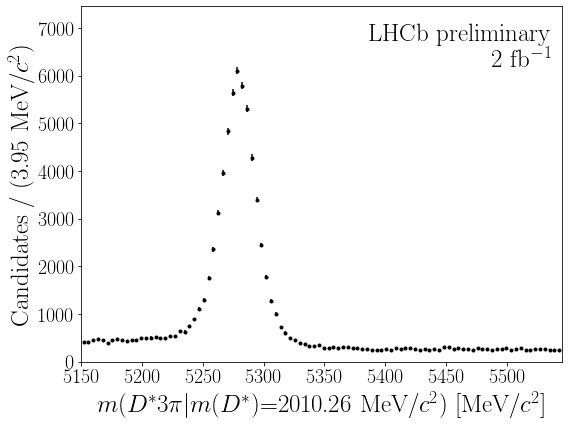

In [10]:
h.plot_hist_particle({name_data:df}, var,
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black', pos_text_LHC='right')

### Initial values

In [11]:
variables_data = ['mu', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'frac', 'n_sig', 'lambda', 'n_bkg', 'r_bkgK']

initial_values = {}

for variable in variables_data:
    initial_values[variable] = {'value': data_params[variable], 'floating': True}
initial_values['nR'] = {'value': MC_param_results['nR_MC']     , 'floating': False}

for variable in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{variable}_K'] = {'value': data_KPiPi_params[variable], 'low': None, 'high': None, 'floating': False}

for variable in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{variable}_Ds'] = {'value': data_DstDs_params[f'{variable}_DstDs'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [12]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

### PDFs

In [13]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_Ds_ext = gaussian_Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df[var], obs=obs)

### Plot

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:552: UserWarning: The function <function Space.limits at 0x7fb8197f24d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])


Number of bins: 100
Width of the bins: 3.9499999999989086

Number of d.o.f. in the model:  11
Reduced chi2:  1.2175127523713811

Mean of the normalised residuals: -0.014934191458323079
Std of the normalised residuals: 1.0408474045392124


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (3.95 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.22)', ylabel='residuals / $\\sigma$'>)

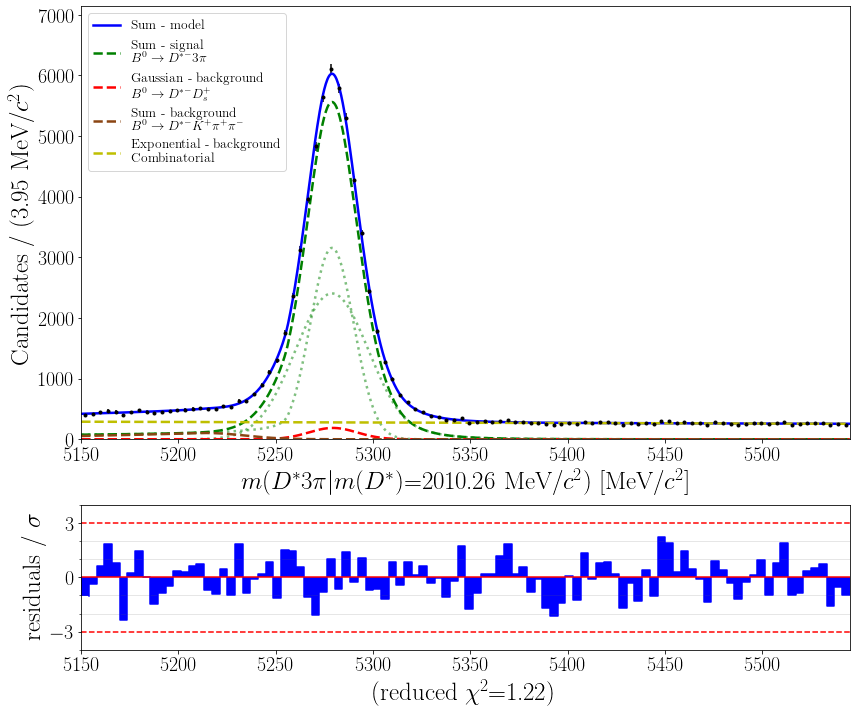

In [14]:
name_data_plot = name_data + '_details'
plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'],
                       fontsize_leg=13.5, show_chi2=True,
                       colWidths=[0.06,0.01,0.05,0.06], 
                      )


Number of bins: 100
Width of the bins: 3.9499999999989086

Number of d.o.f. in the model:  11
Reduced chi2:  1.2175127523713811

Mean of the normalised residuals: -0.014934191458323079
Std of the normalised residuals: 1.0408474045392124


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (3.95 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

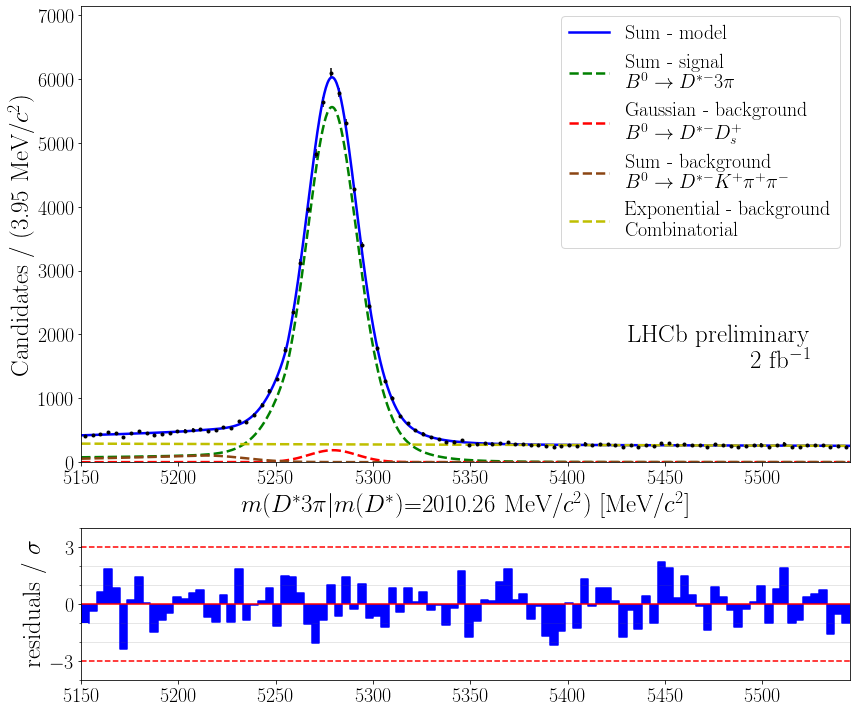

In [15]:
name_data_plot = name_data
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

## Compute sWeights associated with the normalisation mode

In [16]:
from hepstats import splot
import matplotlib.pyplot as plt

In [17]:
weights_hep = splot.compute_sweights(model, data)

In [18]:
weights_sig = weights_hep[zparams['n_sig']]
mass = df[var]

### Plot

In [19]:
from variables import particle_names

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


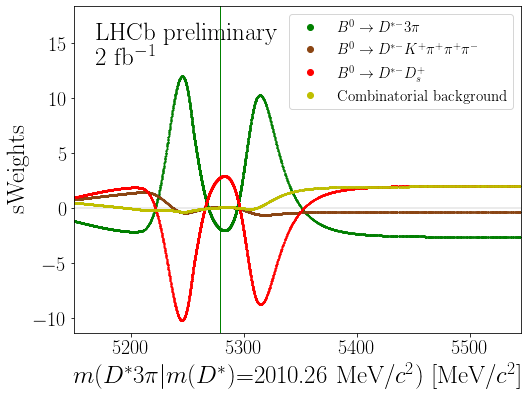

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/sWeights


In [23]:
fig, ax = plt.subplots(figsize=(8,6))

ax.axhline(0, c='black', ls='-', alpha=0.1)
ax.axvline(x=float(zparams['mu']), color='green', linewidth=1.)

n = 5

ax.plot(mass[::n], weights_hep[zparams['n_sig']][::n],'.', label='$B^0 \\to D^{*-} 3\pi$', markersize=1., color='g')
ax.plot(mass[::n], weights_hep[zparams['n_bkgK']][::n],'.', label='$B^0 \\to D^{*-} K^+ \pi^+ \pi^+ \pi^-$', markersize=1., color='saddlebrown')
ax.plot(mass[::n], weights_hep[zparams['n_sig_Ds']][::n],'.', label='$B^0 \\to D^{*-} D_s^+$', markersize=1., color='r')
ax.plot(mass[::n], weights_hep[zparams['n_bkg']][::n],'.', label='Combinatorial background', markersize=1., color='y')

ax.set_xlim(low, high) 
fix_plot(ax, ymax=None)

ax.set_xlabel(f"$m$({particle_names['Dst_constr_B0']}) [MeV/$c^2$]",fontsize=25)
ax.set_ylabel('sWeights',fontsize=25)

ymin, ymax = ax.get_ylim()
#ax.set_ylim(ymin, ymax*1.1)
fix_plot(ax, ymax=1.4, pos_text_LHC=[0.05, 0.95, 'left'], ymin_to0=False)
ax.legend(markerscale=12, fontsize=15)


plt.show()
plt.close()

save_file(fig, 'sWeights', name_folder=name_data)

### Save the dataframe

In [22]:
df['sWeight'] = weights_sig

In [23]:
# save_dataframe(df, name_data+'_sWeights', 'DecayTree', name_folder='common')

In [24]:
save_dataframe(df, name_data+'_sWeights_BDT', 'DecayTree', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0TODst3pi_Dst_constr_sWeights_BDT.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.2)'>)

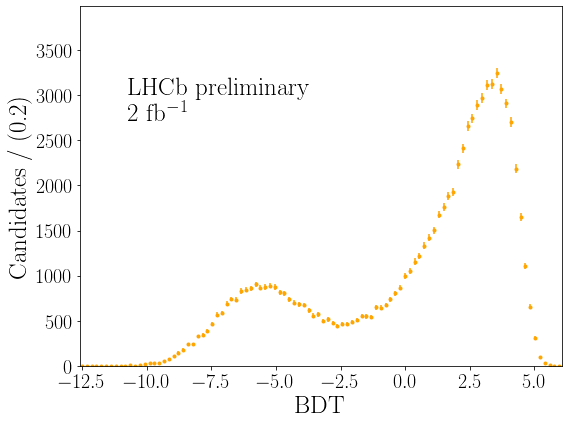

In [25]:
h.plot_hist_particle({'data': df}, 'BDT',
              n_bins = 100, mode_hist = False, colors=['orange'], pos_text_LHC=[0.1,0.8,'left'])